# What programming languages are people using currently and what is their growth?

- Python is consistently the most popular programming language for Jupyter notebooks. There are over 100 times more notebooks written in Python than there are in the next most popular language, Julia. Julia and R are very close in popularity. Many other languages are used (e.g. scala, bash, c++, ruby), but with minimal frequency. 

- The relative popularities of these languages do not change over time (that is, popularity scaled for overall increase in number of notebooks does not change).

- The overall growth in notebook usage (which closely matches the growth within each language) followed an exponential pattern until the last two months, when the number of notebooks has spiked.
-------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statistics
import math
import altair as alt
import calendar
import statsmodels.api as sm
import statsmodels


In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load()

In [3]:
python_versions_strings = notebooks[notebooks.lang_name == 'python'].lang_version
str_to_version = {}
for p in python_versions_strings.unique():
    if p == 'nan':
        str_to_version[p] = ''
    else:
        str_to_version[p] = float('.'.join(str(p).split('.')[0:2]))

In [4]:
DATE_CHOICE = 'pushed_at' # other option: created_at

In [5]:
notebooks['python_version'] = ['' if p.lang_name != 'python' else str_to_version[p.lang_version] for i, p in notebooks.iterrows()]
over_time = notebooks.merge(repos, on = 'repo_id')[['file','lang_name','python_version',DATE_CHOICE]]
over_time[DATE_CHOICE] = pd.to_datetime(over_time[DATE_CHOICE])
over_time['month'] = [c.month for c in over_time[DATE_CHOICE]]
over_time['year'] = [c.year for c in over_time[DATE_CHOICE]]
over_time.head()

,file,lang_name,python_version,pushed_at,month,year
0,danielcorbett..pyoz..scratchwork..notebooks..p...,python,3.5,2019-07-10 00:08:32+00:00,7,2019
1,douglaswinstonr..rideshare_apps_price_mining.....,python,3.7,2019-07-11 12:08:21+00:00,7,2019
2,Flare-k..rokkyw..khukyw_Python...ipynb_checkpo...,NaN,,2019-07-03 14:23:42+00:00,7,2019
3,Flare-k..rokkyw..khukyw_Python..Step_02_Variab...,python,3.7,2019-07-03 14:23:42+00:00,7,2019
4,vishalrajak..Machine-Learning-and-AI..NLP..nlp...,python,3.7,2019-07-11 02:54:42+00:00,7,2019


# Language Use
What programming langugages are the most popular to use with Jupyter notebooks?

In [6]:
counts = notebooks.groupby('lang_name')['file'].count().sort_values(ascending=False).reset_index().rename(
    columns = {'file':'count'}
)

In [7]:
notebooks_has_lang = notebooks[~notebooks.lang_name.isna()]
print("{0}% of notebooks have a specified language.".format(
    round(100*len(notebooks_has_lang)/len(notebooks), 2)
))

print("Of these, {0}% are written in python, {1}% Julia, and {2}% R.".format(
    round(100*sum(notebooks_has_lang.lang_name == 'python') / len(notebooks_has_lang), 2),
    round(100*sum(notebooks_has_lang.lang_name == 'julia') / len(notebooks_has_lang), 2),
    round(100*sum(notebooks_has_lang.lang_name == 'r') / len(notebooks_has_lang), 2)
))

80.64% of notebooks have a specified language.
Of these, 97.9% are written in python, 0.66% Julia, and 0.56% R.


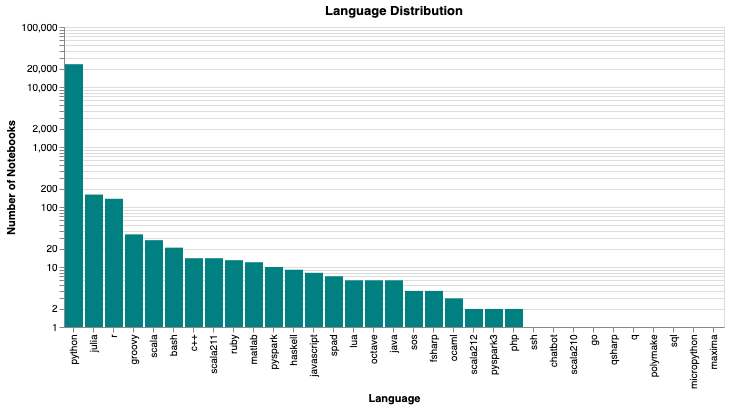

In [8]:
alt.Chart(counts, title = 'Language Distribution').mark_bar(color = 'teal').encode(
    alt.X('lang_name', 
          sort = alt.EncodingSortField(field="count", op="sum",order="descending"),
          title='Language'
    ),
    alt.Y('count', 
          scale = alt.Scale(type='log'),
          title='Number of Notebooks'
    )
)

Clearly, Python is the language of choice. Python has nearly 100 times more notebooks than Julia or R, the next most popular languages.

# Language Use Over Time
How have relative popularities of langages canged over time?

In [8]:
start = over_time.year.min()
end = over_time.year.max()

In [9]:
def lang_over_time(language):
    language_over_time = over_time[over_time.lang_name == language]
    language_yearly_counts = language_over_time.groupby('year')['file'].count().reset_index().rename(columns={'file':'count'})
    to_append = {'year':[], 'count':[]}
    for y in range(start, end):
        if y not in language_yearly_counts['year'].values:
            to_append['year'].append(y)
            to_append['count'].append(0)
    to_append_df = pd.DataFrame(to_append)
    language_yearly_counts = pd.concat([language_yearly_counts, to_append_df], sort = False).sort_values(by='year')
    totals = over_time.groupby('year')['file'].count().reset_index().rename(columns={'file':'total'})
    language_yearly_counts = language_yearly_counts.merge(totals, on = 'year')
    language_yearly_counts['language'] = language
    return language_yearly_counts

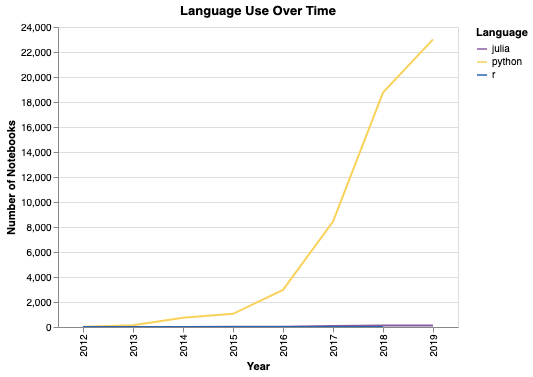

In [10]:
py_counts = lang_over_time('python')
ju_counts = lang_over_time('julia')
r_counts = lang_over_time('r')

lang_counts = pd.concat([py_counts, ju_counts, r_counts])
lang_counts['prop'] = lang_counts['count']/lang_counts['total']

alt.Chart(lang_counts, width = 400, title = 'Language Use Over Time').mark_line().encode(
    alt.X('year:O', title = 'Year'),
    alt.Y('count', title = 'Number of Notebooks'),
    alt.Color('language', 
              scale = alt.Scale(domain = ['julia','python','r'], range = ['#8A5D9F','#F9D25B','#2A65B3']),
              title = 'Language'
    )
)

Python has always been the most popular language. The number of notebooks written in each language grows as the total number of notebooks written does, so let's instead look at the proportion within each year.

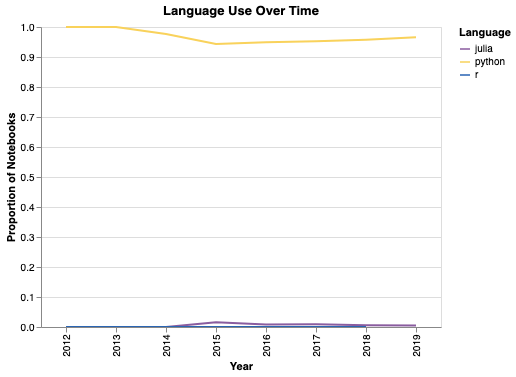

In [11]:
alt.Chart(lang_counts, width = 400, title = 'Language Use Over Time').mark_line().encode(
    alt.X('year:O', title = 'Year'),
    alt.Y('prop', title = 'Proportion of Notebooks'),
    alt.Color('language', 
              scale = alt.Scale(domain = ['julia','python','r'], range = ['#8A5D9F','#F9D25B','#2A65B3']),
              title = 'Language'
    )
)

Here we see the same thing, that nearly all notebooks are written in Python, and this popularity has not fluxuated that much over time. It's difficult to see the difference between the lines for Julia and R, so lets zoom in on those.

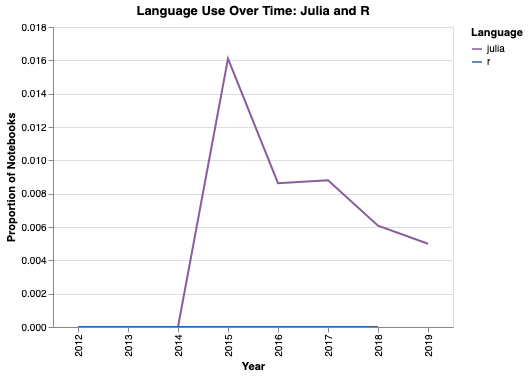

In [12]:
alt.Chart(
    lang_counts[lang_counts['language'] != 'python'], 
    width = 400, 
    title = 'Language Use Over Time: Julia and R'
).mark_line().encode(
    alt.X('year:O', title = 'Year'),
    alt.Y('prop', title = 'Proportion of Notebooks'),
    alt.Color('language', 
              scale = alt.Scale(domain = ['julia','r'], range = ['#8A5D9F','#2A65B3']),
              title = 'Language'
    )
)

# Python Version Use


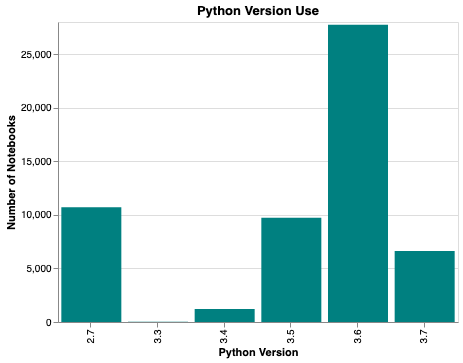

In [13]:
counts = pd.Series(notebooks.python_version[notebooks.python_version != '']).value_counts()
counts = pd.DataFrame(counts).reset_index().rename(columns={'index':'version','python_version':'counts'})
counts.version = counts.version.astype('float')
counts = counts.sort_values(by='version')

alt.Chart(counts, width = 400, title = 'Python Version Use').mark_bar(color='teal').encode(
    alt.X('version:O', title = "Python Version"),
    alt.Y('counts', title = 'Number of Notebooks')
)

Python 3.6 is the most common within Jupyter notebooks. Almost no notebooks were written in Python 3.3 (released September 2012) or 3.4 (March 2014).

In [14]:
yearly_version_counts = over_time[over_time['lang_name']=='python'].groupby(['year', 'python_version'])['file']\
    .count().reset_index().rename(columns={'file':'count'})
yearly_totals = yearly_version_counts.groupby('year')[['count']].sum().reset_index().rename(columns={'count':'total'})
yearly_version_counts = yearly_version_counts.merge(yearly_totals, on = 'year')
yearly_version_counts['prop'] = yearly_version_counts['count']/yearly_version_counts['total']
yearly_version_counts.head()

,year,python_version,count,total,prop
0,2014,2.7,1,1,1.000000
1,2015,2.7,391,530,0.737736
2,2015,3.3,8,530,0.015094
3,2015,3.4,119,530,0.224528
4,2015,3.5,12,530,0.022642


In [15]:
all_counts = pd.DataFrame({'year':[], 'count':[], 'prop':[], 'version':[]})
start = yearly_version_counts.year.min()
end = yearly_version_counts.year.max()
    
for version in [2.7, 3.4, 3.5, 3.6, 3.7]:
    version_counts = yearly_version_counts[yearly_version_counts['python_version']==version]
    to_append = {'year':[], 'count': [], 'prop':[], 'version':[]}
    for year in range(start,end):
        if year not in version_counts['year'].values:
            to_append['year'].append(year)
            to_append['count'].append(0)
            to_append['prop'].append(0)
            to_append['version'].append(version)
    to_append_df = pd.DataFrame(to_append)            
    if len(to_append_df) > 0:
        version_counts = pd.concat([version_counts, to_append_df], sort = False).sort_values(by='year')
    version_counts['version'] = [version]*len(version_counts)
    all_counts = pd.concat([all_counts, version_counts], sort = False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


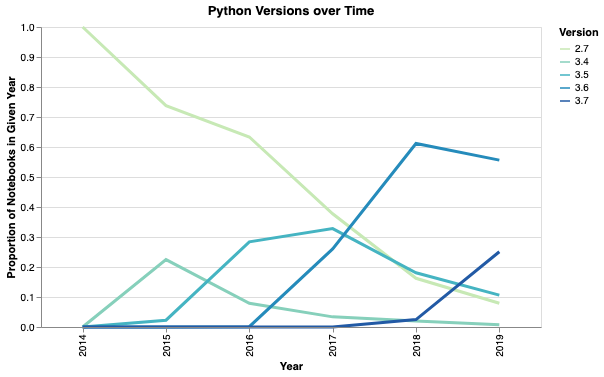

In [16]:
alt.Chart(all_counts, width = 500, title = "Python Versions over Time").mark_line(strokeWidth=3).encode(
    alt.X('year:O', title='Year'),
    alt.Y('prop', title='Proportion of Notebooks in Given Year'),
    alt.Color('version:O', scale=alt.Scale(scheme='yellowgreenblue'), title = 'Version')
)

In [17]:
monthly_version_counts = over_time[over_time['lang_name']=='python'].groupby(['year', 'month', 'python_version'])['file']\
    .count().reset_index().rename(columns={'file':'count'})
monthly_totals = monthly_version_counts.groupby(['year','month'])[['count']].sum().reset_index().rename(columns={'count':'total'})
monthly_version_counts = monthly_version_counts.merge(monthly_totals, on = ['year','month'])
monthly_version_counts['prop'] = monthly_version_counts['count']/monthly_version_counts['total']
monthly_version_counts['time'] = [(int(r['year']), int(r['month'])) for _, r in monthly_version_counts.iterrows()]

In [18]:
monthly_counts = pd.DataFrame({'year':[], 'month': [], 'time': [], 'count':[], 'prop':[], 'version':[]})
start_year = yearly_version_counts.year.min()
end_year = yearly_version_counts.year.max()
    
for version in [2.7, 3.4, 3.5, 3.6, 3.7]:
    version_counts = monthly_version_counts[monthly_version_counts['python_version']==version]
    to_append = {'year':[], 'month': [], 'count': [], 'time': [], 'prop':[], 'version':[]}
    for year in range(start_year,end_year):
        for month in range(1,13):
            if (year, month) not in list(version_counts['time'].values):
                to_append['year'].append(year)
                to_append['month'].append(month)
                to_append['time'].append((year, month))
                to_append['count'].append(0)
                to_append['prop'].append(0)
                to_append['version'].append(version)
    to_append_df = pd.DataFrame(to_append) 
    if len(to_append_df) > 0:
        version_counts = pd.concat([version_counts, to_append_df], sort = False).sort_values(by='time')
    version_counts['version'] = [version]*len(version_counts)
    monthly_counts = pd.concat([monthly_counts, version_counts], sort = False).sort_values(by='time')

In [19]:
monthly_counts['order'] = list(range(len(monthly_counts)))
first = calendar.month_name[int(monthly_counts.iloc[0]['month'])] +' of '+ str(int(monthly_counts.iloc[0]['year']))

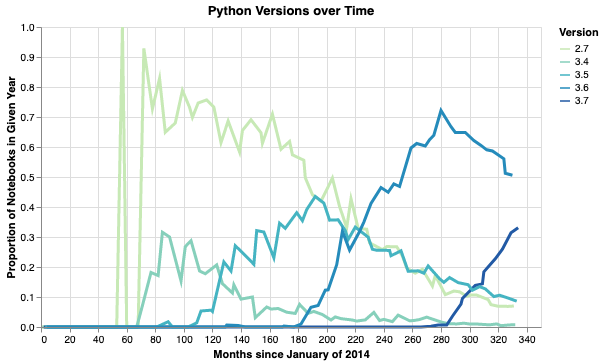

In [20]:
alt.Chart(monthly_counts, width = 500, title = "Python Versions over Time").mark_line(strokeWidth=3).encode(
    alt.X('order', title='Months since '+first),
    alt.Y('prop', title='Proportion of Notebooks in Given Year'),
    alt.Color('version:O', scale=alt.Scale(scheme='yellowgreenblue'), title = 'Version')
)

Release dates all make sense with this visualization ([reference](https://en.wikipedia.org/wiki/History_of_Python)):
- 2.7: July 2010
- 3.3: September 2012
- 3.4: March 2014
- 3.5: September 2015
- 3.6: December 2016
- 3.7: June 2018

<center> <a href = 1_Popularity.ipynb>Notebook Popularity &lt;</a> | <a href = 3_Frameworks.ipynb>&gt; ML Framework Use</a> <center>